In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from datetime import datetime

import pandas as pd
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets

## Load data from source

In [3]:
repo = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19'
branch = f'{repo}/master'

confirmed_df = pd.read_csv(f'{branch}/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
recovered_df = pd.read_csv(f'{branch}/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
death_df = pd.read_csv(f'{branch}/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

country_df = pd.read_csv(f'{repo}/web-data/data/cases_country.csv', parse_dates=['Last_Update'])

print(f'TimeSeries last date:\t'
      f'{datetime.strptime(confirmed_df.columns[-1], "%m/%d/%y"):"%Y-%m-%d"}')
print(f'country_df last_update:\t{country_df.Last_Update.max():"%Y-%m-%d"}')

TimeSeries last date:	"2021-01-19"
country_df last_update:	"2021-01-20"


#### Rename the columns

to make them lowercase and a single word for easier navigation and usage throughout your analysis.

In [4]:
confirmed_df.columns[:5]

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20'], dtype='object')

In [5]:
for df in [confirmed_df, recovered_df, death_df]:
    df.rename(columns={
        'Province/State': 'state',
        'Country/Region': 'country',
        'Lat': 'lat',
        'Long': 'long',
    }, inplace=True)

country_df.columns = country_df.columns.str.lower()

In [6]:
confirmed_df.columns[:5]
country_df.columns[:5]

Index(['state', 'country', 'lat', 'long', '1/22/20'], dtype='object')

Index(['country_region', 'last_update', 'lat', 'long_', 'confirmed'], dtype='object')

## Explore the aggregate numbers

for each category of cases (confirmed/deaths/recovered/active) in the world.

In [7]:
country_df.info()
country_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   country_region       191 non-null    object        
 1   last_update          191 non-null    datetime64[ns]
 2   lat                  189 non-null    float64       
 3   long_                189 non-null    float64       
 4   confirmed            191 non-null    float64       
 5   deaths               191 non-null    float64       
 6   recovered            187 non-null    float64       
 7   active               191 non-null    float64       
 8   incident_rate        189 non-null    float64       
 9   people_tested        0 non-null      float64       
 10  people_hospitalized  0 non-null      float64       
 11  mortality_rate       191 non-null    float64       
 12  uid                  191 non-null    int64         
 13  iso3                 189 non-null  

,country_region,last_update,lat,long_,confirmed,deaths,recovered,active,incident_rate,people_tested,people_hospitalized,mortality_rate,uid,iso3
0,Afghanistan,2021-01-20 20:22:26,33.93911,67.709953,54278.0,2354.0,46759.0,5165.0,139.430550,NaN,NaN,4.336932,4,AFG
1,Albania,2021-01-20 20:22:26,41.15330,20.168300,69238.0,1291.0,41969.0,25978.0,2405.935089,NaN,NaN,1.864583,8,ALB
2,Algeria,2021-01-20 20:22:26,28.03390,1.659600,104341.0,2843.0,70933.0,30565.0,237.944169,NaN,NaN,2.724720,12,DZA


In [8]:
country_df.last_update.min(), country_df.last_update.max()

(Timestamp('2021-01-20 20:22:26'), Timestamp('2021-01-20 20:22:26'))

In [9]:
country_df[['confirmed', 'deaths', 'recovered', 'active']].sum().map(lambda x: f'{x:,.0f}')

confirmed    96,594,427
deaths        2,067,611
recovered    53,241,716
active       41,285,024
dtype: object

In [10]:
# How accurate is this partitioning of confirmed cases?

print(f"{country_df[['deaths', 'recovered', 'active']].sum().sum():,.0f}")

96,594,351


## Display countries sorted by the total number of confirmed cases

In [11]:
print('Top 10 (highest number of confirmed)')

top10 = (country_df[['country_region', 'confirmed']]
         .sort_values('confirmed', ascending=False)
         .head(10))

top10.style.format({'confirmed': '{:,.0f}'})

Top 10 (highest number of confirmed)


,country_region,confirmed
177,US,"24,356,741"
79,India,"10,595,660"
23,Brazil,"8,573,864"
141,Russia,"3,595,136"
181,United Kingdom,"3,515,796"
62,France,"3,023,400"
85,Italy,"2,414,166"
161,Spain,"2,412,318"
176,Turkey,"2,406,216"
66,Germany,"2,090,098"


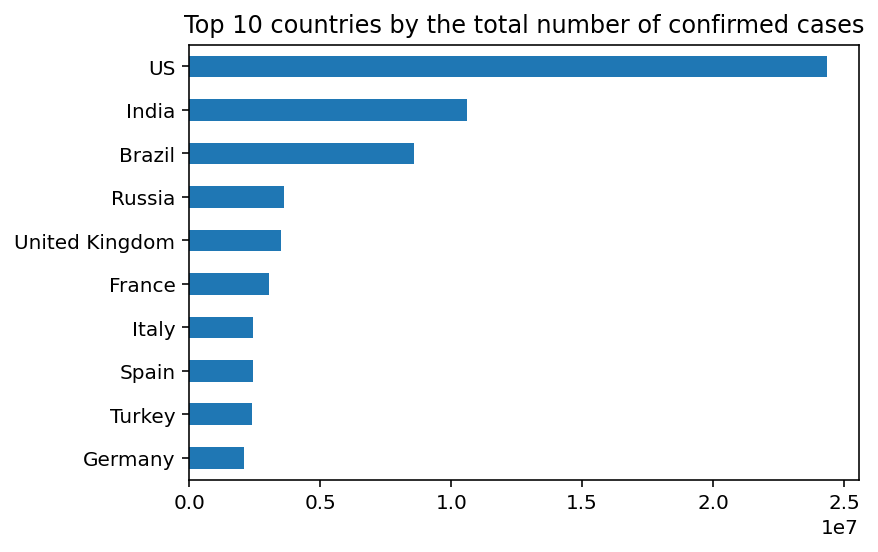

In [12]:
ax = (top10
      .rename(columns={'country_region': 'country'})
      .set_index('country')
      .sort_values('confirmed')
      .plot.barh(title='Top 10 countries by the total number of confirmed cases', legend=False))

_ = ax.set_ylabel(None)

In [13]:
print('Lower 10 (lowest number of confirmed)')

lower10 = (country_df[['country_region', 'confirmed']]
           .sort_values('confirmed', ascending=True)
           .head(10))

lower10.style.format({'confirmed': '{:,.0f}'})

Lower 10 (lowest number of confirmed)


,country_region,confirmed
184,Vanuatu,1
146,Samoa,2
111,Marshall Islands,4
104,MS Zaandam,9
157,Solomon Islands,17
75,Holy See,27
143,Saint Kitts and Nevis,35
95,Laos,41
172,Timor-Leste,53
60,Fiji,55


## Plot the daily confirmed/recovered/deaths with an option to choose the country

In [14]:
confirmed_df.columns.tolist() == recovered_df.columns.tolist()
recovered_df.columns.tolist() == death_df.columns.tolist()

True

True

Reshape each DataFrame such that index is the dates and the columns are the country names.

In [15]:
source_dfs = []
for i, df in enumerate([confirmed_df, recovered_df, death_df]):
    if i != 1:  # Ignore this step for recovered_df
        canada = df[df.country == 'Canada'].mean().round().append(pd.Series({'country': 'Canada'}))
        df = df.append(canada, ignore_index=True)
    
    df = (df[df.state.isnull()]
          .copy()
          .drop(columns=['state', 'lat', 'long'])
          .set_index('country')
          .sort_index()
          .transpose()
          .fillna(0)
          .astype(int))
    df.index = pd.DatetimeIndex(data=df.index.values)
    df.index.name = None
    df.columns.name = None
    
    source_dfs.append(df)

# Check columns agree
[(i, len(df.columns)) for i, df in enumerate(source_dfs)]
    
source_dfs[0].info()
source_dfs[0].head(3)

[(0, 189), (1, 189), (2, 189)]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 364 entries, 2020-01-22 to 2021-01-19
Columns: 189 entries, Afghanistan to Zimbabwe
dtypes: int64(189)
memory usage: 540.3 KB


,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Austria,Azerbaijan,...,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0


In [16]:
countries = source_dfs[0].columns.tolist()

w = widgets.Combobox(
    placeholder='Choose Country',
    options=countries,
    description='Country:',
    ensure_option=True,
    disabled=False
)

@widgets.interact(country=w)
def daily_stats(country):
    if country:
        fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(8, 12), sharex=True)
        for i, (df, label) in enumerate(zip(source_dfs, ['confirmed', 'recovered', 'deaths'])):
            _ = df[country].plot(ax=axes[i], label=label, legend=True)
        axes[0].set_title(country)

interactive(children=(Combobox(value='', description='Country:', ensure_option=True, options=('Afghanistan', '…

## Display the COVID-19 spread on a global map using Folium

In [17]:
country_df[country_df.country_region == 'United Kingdom']

,country_region,last_update,lat,long_,confirmed,deaths,recovered,active,incident_rate,people_tested,people_hospitalized,mortality_rate,uid,iso3
181,United Kingdom,2021-01-20 20:22:26,55.0,-3.0,3515796.0,93469.0,8477.0,3413850.0,5178.970322,NaN,NaN,2.658544,826,GBR


In [18]:
print(f'{3476827.0 - 91643.0 - 8394.0:,}')

3,376,790.0


In [19]:
import folium

In [20]:
world_map = folium.Map(location=(11, 0), zoom_start=2, min_zoom=2, max_zoom=6)

for row in country_df.itertuples(index=False):
    if (not np.isnan(row.lat)) and (not np.isnan(row.long_)):
        _ = folium.Circle(
            location=(row.lat, row.long_),
            fill=True,
            radius=(int( np.log(row.active + 1.00001) ) + 0.2) * 15_000,
            color='red',
            fill_color='indigo',
            tooltip=(f'<div>'
                     f'<h4 style="text-align: center; font-weight: bold">{row.country_region}</h4>'
                     f'<hr style="margin: 10px;">'
                     f'<ul style="list-style-type: circle; align-item: left; padding-left: 20px; padding-right: 20px">'
                         f'<li>confirmed:      {row.confirmed:,}</li>'
                         f'<li>deaths:         {row.deaths:,}</li>'
                         f'<li>recovered:      {row.recovered:,}</li>'
                         f'<li>active:         {row.active:,}</li>'
                         f'<li>mortality rate: {row.mortality_rate:.1f}</li>'
                     f'</ul></div>'),
        ).add_to(world_map)

world_map